In [1]:
#!pip install google-cloud-bigquery[pandas]
#!pip install seaborn

In [2]:
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
%%capture
client = bigquery.Client(project='api-project-764811344545')

In [4]:
upw_08_12 = '`oadoi_full.mongo_export_upwNov19_08_12`'
upw_13_19 = '`oadoi_full.mongo_export_upwNov19_13_19`'

In [5]:
client.query(f'SELECT * FROM {upw_13_19} WHERE year=2018 AND genre="journal-article" LIMIT 10').to_dataframe()

,oa_status,year,genre,updated,published_date,journal_is_in_doaj,journal_is_oa,journal_issns,oa_locations,doi,is_oa,publisher,journal_name,data_standard
0,gold,2018,journal-article,2019-11-01 22:51:32.142428+00:00,2018-03-29,True,True,1560-7917,[{'url': 'https://doi.org/10.2807/1560-7917.es...,10.2807/1560-7917.es.2018.23.13.180329-3,True,European Centre for Disease Control and Preven...,Eurosurveillance,2
1,bronze,2018,journal-article,2019-10-31 06:40:37.599979+00:00,2018-01-01,False,False,"0035-2764,1950-6694",[{'url': 'https://www.cairn.info/load_pdf.php?...,10.3917/reco.695.0683,True,CAIRN,Revue économique,2
2,gold,2018,journal-article,2019-10-31 16:20:21.743703+00:00,2018-03-12,True,True,1664-3224,[{'url': 'https://www.frontiersin.org/articles...,10.3389/fimmu.2018.00438,True,Frontiers Media SA,Frontiers in Immunology,2
3,gold,2018,journal-article,2019-11-07 06:20:25.027034+00:00,2018-08-07,True,True,2045-2322,[{'url': 'https://www.nature.com/articles/s415...,10.1038/s41598-018-29997-0,True,"Springer Nature America, Inc",Scientific Reports,2
4,gold,2018,journal-article,2019-11-01 04:59:15.673051+00:00,2018-01-26,True,True,1664-302X,[{'url': 'https://www.frontiersin.org/articles...,10.3389/fmicb.2018.00019,True,Frontiers Media SA,Frontiers in Microbiology,2
5,green,2018,journal-article,2019-11-14 20:18:43.150844+00:00,2018-12-07,False,False,"0305-8719,2041-4927",[{'url': 'https://hal.archives-ouvertes.fr/hal...,10.1144/sp467.15,True,Geological Society of London,"Geological Society, London, Special Publications",2
6,green,2018,journal-article,2019-11-16 23:50:30.876520+00:00,2018-11-29,False,False,"2470-0010,2470-0029",[{'url': 'https://helda.helsinki.fi/bitstream/...,10.1103/physrevd.98.103533,True,American Physical Society (APS),Physical Review D,2
7,gold,2018,journal-article,2019-11-16 20:20:50.499946+00:00,2018-01-23,False,True,2291-0026,[{'url': 'http://www.cmajopen.ca/content/6/1/E...,10.9778/cmajo.20170159,True,Joule Inc.,CMAJ Open,2
8,green,2018,journal-article,2019-10-31 01:01:45.923146+00:00,2018-10-06,False,False,"1387-2877,1875-8908",[{'url': 'http://spiral.imperial.ac.uk/bitstre...,10.3233/jad-180101,True,IOS Press,Journal of Alzheimer's Disease,2
9,gold,2018,journal-article,2019-10-31 10:50:00.933552+00:00,2018-04-10,True,True,1664-462X,[{'url': 'https://www.frontiersin.org/articles...,10.3389/fpls.2018.00470,True,Frontiers Media SA,Frontiers in Plant Science,2


In [6]:
# Queries oder Umwandlung in Dataframe ziemlich langsam
# Limit auf 50000 gesetzt

In [7]:
oa_08_12 = client.query(f'SELECT * FROM {upw_08_12} WHERE genre="journal-article" LIMIT 50000').to_dataframe()
oa_13_19 = client.query(f'SELECT * FROM {upw_13_19} WHERE year<2019 AND genre="journal-article" LIMIT 50000').to_dataframe()

In [8]:
oa_08_12 = oa_08_12.groupby(['year', 'is_oa']).size().reset_index(name='n')
oa_13_19 = oa_13_19.groupby(['year', 'is_oa']).size().reset_index(name='n')

In [9]:
df = pd.concat([oa_08_12, oa_13_19])
df.year = pd.to_datetime(df.year.apply(lambda x: str(x) + "-01-01"))
df['prop'] = df.groupby(['year'])['n'].transform(lambda x: x / x.sum())
df

,year,is_oa,n,prop
0,2008-01-01,False,6166,0.875852
1,2008-01-01,True,874,0.124148
2,2009-01-01,False,7741,0.865496
3,2009-01-01,True,1203,0.134504
4,2010-01-01,False,11628,0.888651
5,2010-01-01,True,1457,0.111349
6,2011-01-01,False,7937,0.809568
7,2011-01-01,True,1867,0.190432
8,2012-01-01,False,8621,0.774782
9,2012-01-01,True,2506,0.225218


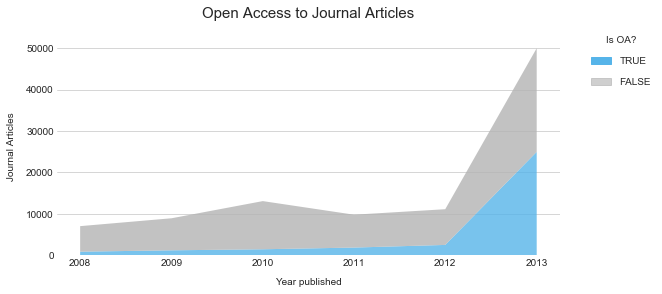

In [10]:
x = df.year.unique()
y1 = df[df.is_oa == True].n
y2 = df[df.is_oa == False].n

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [9, 4]
plt.grid(False, which='both', axis='x')
plt.box(False)
plt.stackplot(x, y1, y2, colors=['#56B4E9', '#b3b3b3a0'], alpha=0.8)
plt.title('Open Access to Journal Articles', fontdict={'fontsize': 15, 'fontweight': 500}, pad=20)
plt.xlabel('Year published', labelpad=10)
plt.ylabel('Journal Articles', labelpad=10)
is_oa_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
plt.legend(handles=[is_oa_patch, is_not_oa_patch], title='Is OA?', fontsize='medium', bbox_to_anchor=(1.2, 1.05), labelspacing=1.2)

plt.show()